# Construction du graphe des structures actives

In [26]:
import pandas as pd
import io
import requests

from py2neo import Graph, Node, Relationship
from py2neo.database import Schema


## Connexion à la base neo4j en ligne

Pour cette démonstration, je vais prendre une base temporaire en ligne proposé par la société neo4j.

* Aller sur https://neo4j.com/sandbox-v2/
* Demander à voir une _blank box_
* pour avoir les paramétres de connexion, allez dans l'onglet **details**

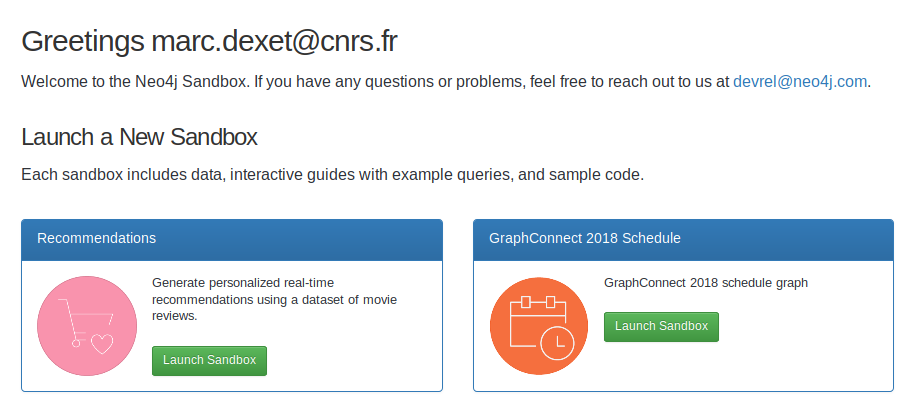




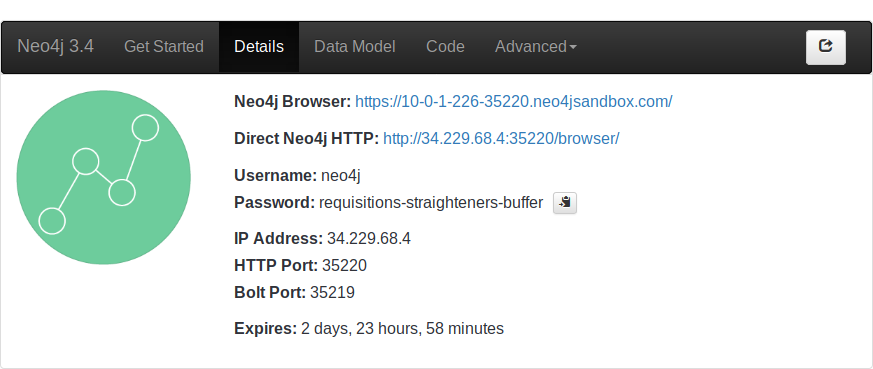

In [43]:
#graph = Graph("bolt://34.229.68.4:35219",auth=("neo4j", "requisitions-straighteners-buffer"))
graph = Graph()
schema = Schema(graph)

NameError: name 'py2neo' is not defined

In [44]:
schema.create_index("Structure",'numero_national_de_structure')

RuntimeError: Unexpected response from procedure db.indexes (7 fields)

In [45]:
schema.create_index("Tutelle",'label')

RuntimeError: Unexpected response from procedure db.indexes (7 fields)

## Récupération du jeux de données

Le jeux de données utilisé s'appelle _Structures de recherche publiques actives_, disponible sur le site https://data.enseignementsup-recherche.gouv.fr/pages/home/

In [46]:
structure_url = 'https://data.enseignementsup-recherche.gouv.fr/explore/dataset/fr-esr-structures-recherche-publiques-actives/download/?format=json'
structures = pd.read_json(io.StringIO(requests.get(structure_url).content.decode('utf-8')))

In [47]:
print(structures.columns)

Index(['datasetid', 'fields', 'geometry', 'record_timestamp', 'recordid'], dtype='object')


### Identification des données

Je ne suis pas un spécialiste de Pandas et des jeux de données OpenData. Toujours est-il que le champs qui nous intéresse est `fields`.

En voici un exemple:

In [6]:
structures['fields'][0].keys()

dict_keys(['type_de_structure', 'code_de_nature_de_tutelle', 'pays', 'libelle', 'niveau_de_structure', 'uai_des_tutelles', 'email_du_responsable', 'langue_du_libelle', 'nature_de_tutelle', 'code_de_niveau_de_structure', 'url_de_tutelle', 'prenom_du_responsable', 'code_de_type_de_structure', 'sigle', 'lien_historique_annuel', 'scanr', 'annee_de_creation', 'code_du_pays', 'fiche_rnsr', 'tutelles', 'code_de_type_de_tutelle', 'titre_du_responsable', 'siret_des_tutelles', 'nom_du_responsable', 'numero_national_de_structure', 'type_de_tutelle', 'geolocalisation'])

Les champs disponibles sont indiquées dans l'onglet _informations_ de la page web, rubrique _Modèle de données_.

### Modèle de données

Nous allons considérer des structures de recherche de type `Structure` 

## Définition de quelques fonctions pratiques


In [48]:
def create_tutelle_nodes(tutelle_list, tutelle_nodes):
    for tutelle in tutelle_list:
        label, code_type, sigle = tutelle
        node = None
        if label: 
            if label in tutelle_nodes:
                node = tutelle_nodes[label]
            else :
                node = Node('Tutelle')
                tutelle_nodes[label] = node
            if not label:
                print(tutelle)
            node['label'] = label
            if code_type:
                node['type'] = code_type
            if sigle :
                node['sigle'] = sigle
        return node

In [49]:
def create_struct(structure):
    _id = lambda p : p
    _to_int = lambda p : int(p)
    
    scalars_properties = {'numero_national_de_structure': _id, 
                          'libelle': _id,
                          'sigle': _id,
                          'annee_de_creation': _to_int
                         }
    node = Node('Structure')
    for key, fn in scalars_properties.items():
        value = structure.get(key)
        if value : 
            node[key] = fn(value)
            
    return node
    

In [50]:
s_ = lambda s,name : s.get(name,'').split(';')

tutelle_nodes = {}

for structure in structures['fields']:
    tutelle_list = zip(s_(structure,'tutelles'), s_(structure,'code_de_type_de_tutelle'), s_(structure,'sigles_des_tutelles'))
    create_tutelle_nodes(list(tutelle_list), tutelle_nodes)
    
for n in tutelle_nodes.values():
    graph.create(n)



In [51]:
struct_nodes = []
for structure in structures['fields']:    
    node_struct = create_struct(structure)
    graph.create(node_struct)

In [17]:
from py2neo import NodeMatcher

matcher = NodeMatcher(graph)

struct = matcher.match("Structure",numero_national_de_structure="200222184J").first()
tutelle = matcher.match("Tutelle", label="Université de Bordeaux").first()

(struct, tutelle)

((_242:Structure {annee_de_creation: 2002, libelle: "OBSERVATOIRE AQUITAIN DES SCIENCES DE L'UNIVERS", numero_national_de_structure: '200222184J', sigle: 'OASU'}),
 (_0:Tutelle {label: 'Universit\u00e9 de Bordeaux', type: 'UNIV'}))

In [52]:
for structure in structures['fields']:    
    node_struct = create_struct(structure)
    
    tutelle_list = s_(structure,'tutelles')
    
    struct = matcher.match("Structure",numero_national_de_structure=node_struct['numero_national_de_structure']).first()
    
    for position, label in enumerate(tutelle_list):
        tutelle = matcher.match("Tutelle", label=label).first()
        if tutelle:
            depend_on = Relationship(struct,"ATTACHED_TO", tutelle, position=position)
            graph.create(depend_on)


KeyboardInterrupt: 

## Préparation de l'import

Nous allons ajouter quelques index pour faciliter l'import

```cypher
CREATE INDEX ON :Tutelle(label)
CREATE INDEX ON :Structure(numero_national_de_structure)
```